# Neural Image Caption Generation Using Pre-trained ResNet-101 and LSTM with Attention

In this notebook, I train an encoder-decoder model with attention mechanisms for the task of image captioning. The model is trained on the MS COCO dataset, utilizing Karpathy's split, which includes approximately 113,000 high-quality images in the training set.

The encoder is a ResNet-101 convolutional neural network (CNN) pre-trained on large image datasets. While I did not fine-tune the CNN during training, the option to do so is available in the code below. The primary role of the CNN is to generate encoded representations of the image, extracting key features that are subsequently passed into the decoder for further processing.

The LSTM variant of recurrent neural networks (RNN) is chosen as the decoder. The attention mechanism is incorporated while decoding to determine how much attention should be placed on each region in the encoded image. This helps address the main issue with RNNs: their difficulty in handling long sequences of input, especially in cases where important information is spread out across a large number of pixels in the image.

The ADAM optimizer is used to update the model’s weights, offering robust optimization by combining the benefits of adaptive learning rates and momentum. I utilize a learning rate scheduler to dynamically adjust the learning rate during training, helping to achieve more efficient convergence and avoid overshooting minima.


The model I trained reached a top-5 validation accuracy of 76.57% and top-10 validation accuracy of 83.80%. An example image with a generated caption can be seen at the bottom of the notebook.

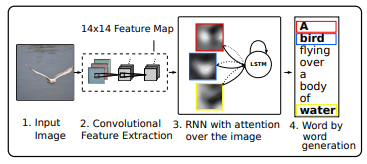

Xu et al., 2016

## Import Libraries

In [ ]:
import os
import json
from collections import Counter
import random
from google.colab import drive

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import skimage.transform


import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="nltk.translate.bleu_score")

from google.colab import drive
drive.mount('/content/drive')

## Download Data

In [ ]:
!wget http://images.cocodataset.org/zips/train2014.zip
!unzip 'train2014.zip'
!rm -r 'train2014.zip'

!wget http://images.cocodataset.org/zips/val2014.zip
!unzip 'val2014.zip'
!rm -r 'val2014.zip'

!wget https://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip
!unzip 'caption_datasets.zip'
!rm -r 'caption_datasets.zip'

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000502055.jpg  
 extracting: val2014/COCO_val2014_000000438848.jpg  
 extracting: val2014/COCO_val2014_000000364973.jpg  
 extracting: val2014/COCO_val2014_000000564166.jpg  
 extracting: val2014/COCO_val2014_000000323327.jpg  
 extracting: val2014/COCO_val2014_000000338581.jpg  
 extracting: val2014/COCO_val2014_000000039656.jpg  
 extracting: val2014/COCO_val2014_000000071667.jpg  
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.jpg  
 extracting: val2014/COCO_val2014_000000383518.jpg  
 extracting: val2014/COCO_val2014_000000262466.jpg  
 extracting: val2014/COCO_val2014_000000153055.jpg  
 extracting: val2014/COCO_val2014_000000155312.jpg  
 extracting: val2014/COCO_val2014_000000010440.jpg  
 extracting: val2014/COCO_val2014_000000541108.jpg  
 extracting: val2014/COCO_val2014_000000202503.j

In [ ]:
print(f"# Training images: {len(os.listdir('train2014'))}")
print(f"# Val images: {len(os.listdir('val2014'))}")

# Training images: 82783
# Val images: 40504


In [ ]:
with open('dataset_coco.json', 'r') as f:
    data = json.load(f)

## Pre-Process Text

In [ ]:
image_folder = '/content'
min_word_freq = 5           # words occuring less than this threshold will be labelled as <unk>
captions_per_image = 5      # number of captions per image
max_len = 100

word_freq = Counter()       # Counter object to find the freq of each word

In [ ]:
for image in data["images"]:
  for sentence in image["sentences"]:
    word_freq.update((word for word in sentence["tokens"]))

In [ ]:
# Most frequent words
word_freq.most_common(10)

[('a', 1019785),
 ('on', 224758),
 ('of', 212689),
 ('the', 206178),
 ('in', 191793),
 ('with', 161216),
 ('and', 146755),
 ('is', 102390),
 ('man', 75957),
 ('to', 71183)]

In [ ]:
# Num of words
len(word_freq.keys())

27929

In [ ]:
# Num of words that appear more than 5 times
words = [word for word in word_freq.keys() if word_freq[word] > min_word_freq]
len(words)

9486

In [ ]:
# Create word/id maps
word2id = {word:id for id, word in enumerate(words, 2)}
word2id['<pad>'] = 0
word2id['<start>'] = 1
word2id['<unk>'] = len(word2id) + 1
word2id['<end>'] = len(word2id) + 1

id2word = {id:word for word, id in word2id.items()}

In [ ]:
# Num images in each split
c = Counter()
for img in data['images']:
  c[img['split']] +=1
c

Counter({'test': 5000, 'restval': 30504, 'val': 5000, 'train': 82783})

In [ ]:
# Grab image paths, captions, and caption lengths

train_image_paths = []
train_image_captions = []
train_caption_lens = []

val_image_paths = []
val_image_captions = []
val_caption_lens = []

test_image_paths = []
test_image_captions = []
test_caption_lens = []


for image in data["images"]:
  captions = []

  # only include captions with < 100 tokens
  for sentence in image["sentences"]:
    if len(sentence['tokens']) <= max_len:
      captions.append(sentence['tokens'])

  # handling images with < or > 5 captions
  if len(captions) < captions_per_image:
      captions += [random.choice(captions) for _ in range(captions_per_image - len(captions))]
  else:
    captions = random.sample(captions, k=captions_per_image)

  assert len(captions) == captions_per_image

  encoded = []
  caption_lens = []

  # encode, pad captions
  for idx, caption in enumerate(captions):
    enc = [word2id['<start>']] + [word2id.get(word, word2id['<unk>']) for word in caption] + [word2id['<end>']] + [word2id['<pad>']] * (max_len - len(caption))
    encoded.append(enc)

    caption_len = len(caption) + 2
    caption_lens.append(caption_len)

  path = os.path.join(image_folder, image['filepath'], image['filename'])

  #store image paths, captions, and caption lengths
  if image['split'] in {"train", "restval"}:
    train_image_paths.append(path)
    train_image_captions.append(encoded)
    train_caption_lens.append(caption_lens)

  elif image['split'] == "val":
    val_image_paths.append(path)
    val_image_captions.append(encoded)
    val_caption_lens.append(caption_lens)

  elif image['split'] == "test":
    test_image_paths.append(path)
    test_image_captions.append(encoded)
    test_caption_lens.append(caption_lens)


assert len(train_image_paths) == len(train_image_captions)
assert len(val_image_paths) == len(val_image_captions)
assert len(test_image_paths) == len(test_image_captions)

In [ ]:
# Connect to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Creating Dataset

In [ ]:
len(train_image_paths)

113287

In [ ]:
len(train_image_captions[0])

5

In [ ]:
train_caption_lens[0]

[13, 14, 12, 10, 13]

In [ ]:
class CaptionDataset(Dataset):
    def __init__(self, image_paths, captions, caption_lens, split, captions_per_image = 5):
        self.image_paths = image_paths
        self.captions = captions
        self.caption_lens = caption_lens
        self.split = split
        self.captions_per_image = captions_per_image

        assert self.split in {'train', 'val', 'test'}

    def __len__(self):
        return len(self.image_paths) * self.captions_per_image

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx // self.captions_per_image]).convert('RGB')
        img = np.array(img)
        img = cv2.resize(img, (256,256))
        img = np.transpose(img, (2,0,1))

        assert img.shape == (3, 256, 256)
        assert np.max(img) <= 255

        img = torch.FloatTensor(img / 255.)
        caption = torch.LongTensor(self.captions[idx // self.captions_per_image][idx % self.captions_per_image])
        caption_len = torch.LongTensor([self.caption_lens[idx // self.captions_per_image][idx % self.captions_per_image]])

        if self.split == 'train':
            return img, caption, caption_len
        else:
            all_captions = torch.LongTensor(self.captions[idx // self.captions_per_image])
            return img, caption, caption_len, all_captions

train_dataset = CaptionDataset(train_image_paths, train_image_captions, train_caption_lens, 'train')
val_dataset = CaptionDataset(val_image_paths, val_image_captions, val_caption_lens, 'val')
test_dataset = CaptionDataset(test_image_paths, test_image_captions, test_caption_lens, 'test')

In [ ]:
print(f"TRAINING:   {len(train_image_paths)} images, {len(train_dataset)} captions")
print(f"VALIDATION: {len(val_image_paths)}   images, {len(val_dataset)}  captions")
print(f"TEST:       {len(test_image_paths)}   images, {len(test_dataset)}  captions")

TRAINING:   113287 images, 566435 captions
VALIDATION: 5000   images, 25000  captions
TEST:       5000   images, 25000  captions


## Data Examples

In [ ]:
def decode_caption(encoded_caption):
    decoded = [id2word[id.item()] for id in encoded_caption if id2word[id.item()] not in ["<start>", "<end>", "<unk>", "<pad>"]]
    return " ".join(decoded)

def display_example(img, caption, all = None):
    if all is not None:
        for c in all:
            print(decode_caption(c))
    else:
        print(decode_caption(caption))

    img = img.numpy().transpose(1,2,0)
    plt.imshow(img)
    plt.axis('off')

opened up umbrellas in different colors and patterns


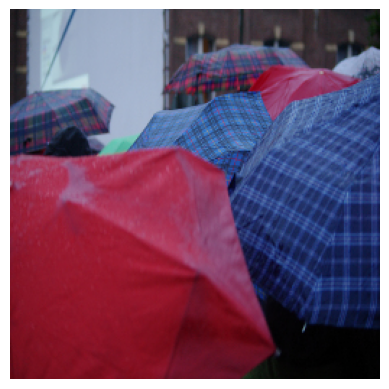

In [ ]:
img, caption, caption_len = train_dataset[24909]
display_example(img, caption)

two teddy bears pose for a picture together
a store features many types of teddy bears with various outfits
a large and a small teddy bear at the teddy bear museum
a brown teddy bear wearing a hawaiian shirt next to another teddy bear
two stuffed bears next to each other one with a hawaiian shirt


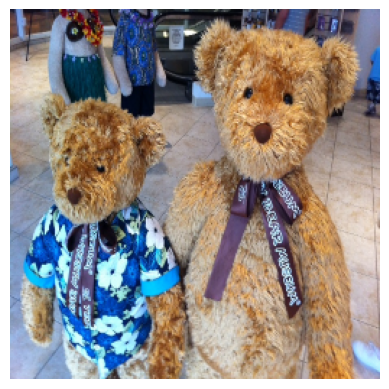

In [ ]:
img, caption, caption_len, all = val_dataset[24999]
display_example(img, caption, all)

## Create DataLoaders

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers=8, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size = 32, shuffle = True, num_workers=8, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = True, num_workers=8, pin_memory=True)

In [ ]:
images, captions, caption_lens = next(iter(train_dataloader))
print(images.shape)
print(captions.shape)
print(caption_lens.shape)

torch.Size([32, 3, 256, 256])
torch.Size([32, 102])
torch.Size([32, 1])


In [ ]:
images, captions, caption_lens, all_captions = next(iter(val_dataloader))
print(images.shape)
print(captions.shape)
print(caption_lens.shape)
print(all_captions.shape)

torch.Size([32, 3, 256, 256])
torch.Size([32, 102])
torch.Size([32, 1])
torch.Size([32, 5, 102])


In [ ]:
images, captions, caption_lens, all_captions = next(iter(test_dataloader))
print(images.shape)
print(captions.shape)
print(caption_lens.shape)
print(all_captions.shape)

torch.Size([32, 3, 256, 256])
torch.Size([32, 102])
torch.Size([32, 1])
torch.Size([32, 5, 102])


## Model Architecture

In [ ]:
class Encoder(nn.Module):
    def __init__(self, enc_image_size = 14):
        super(Encoder, self).__init__()

        self.enc_image_size = enc_image_size

        # Load in resnet
        # resnet = models.resnet50(weights="IMAGENET1K_V2")
        resnet = models.resnet101(weights='DEFAULT')

        # Remove final pooling and FC layer
        modules = list(resnet.children())[:-2]

        self.encoder = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((enc_image_size, enc_image_size))

    def fine_tune(self):
        self.encoder.train()
        pass

    def forward(self, batch): # Takes in tensor of size (32, 3, 256, 256) = (batch size, # channels, height, width)
        out = self.encoder(batch)                              # (32, 2048, 8, 8)
        out = self.adaptive_pool(out)                           # (32, 2048, 14, 14)
        out = out.view(out.size(0), out.size(1), -1)            # (32, 2048, 196)
        out = out.permute(0,2,1)                                # (32, 196, 2048)
        return out            # Outputs tensor of size (32, 196, 2048) = (batch size, seq_length, seq_dim)


# batch_size = 32
# num_pixels = 196 = seq_len
# encoder_dim = 2048 = seq_dim

In [ ]:
# Sanity Check
encoder = Encoder()
test_encoder_out = encoder(images)
test_encoder_out.shape

torch.Size([32, 196, 2048])

In [ ]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)

    def forward(self, encoder_out, decoder_hidden):
        key = self.encoder_att(encoder_out) # (32, 196, 2048)  to (32, 196, 512)
        query = self.decoder_att(decoder_hidden) # (32, 512) to (32, 512)

        att = self.full_att(F.relu(key + query.unsqueeze(1))) # (32, 196, 1)
        alpha = F.softmax(att, dim = 1) # (32, 196, 1)

        att_weighted_encoding = (encoder_out * alpha).sum(dim = 1) # (32, 2048)
        alpha = alpha.squeeze(2) # (32, 196)

        return att_weighted_encoding, alpha

In [ ]:
class Decoder(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim, embed_dim, vocab_size, dropout = 0.5):
        super(Decoder, self).__init__()

        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p = dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)
        self.fc = nn.Linear(decoder_dim, vocab_size)

        self.init_h = nn.Linear(encoder_dim, decoder_dim)   # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)

        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim = 1) # (32, 2048)
        h = self.init_h(mean_encoder_out) # (32, 512)
        c = self.init_c(mean_encoder_out) # (32, 512)
        return h,c

    def forward(self, encoder_out, encoded_captions, caption_lens):
        """
        encoder_out: (32, 196, 2048) - image representations
        encoded_captions: (32, 102) - captions
        caption_lens: (32, 1) - length of each caption
        """
        batch_size = encoder_out.size(0)
        num_pixels = encoder_out.size(1)

        vocab_size = self.vocab_size

        # Sort imgs/caps by decreasing caption length
        caption_lens, sort_idx = caption_lens.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_idx]
        encoded_captions = encoded_captions[sort_idx]

        # Embed captions
        embeddings = self.embedding(encoded_captions)   # (32, 102, 512)

        # Initialize states
        h, c = self.init_hidden_state(encoder_out) # (32, 512)

        # Do not decode after <end> token
        decode_lens = (caption_lens-1).tolist()

        # Create empty word prediction scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lens), vocab_size).to(device) # (32, x, vocabsize)
        alphas = torch.zeros(batch_size, max(decode_lens), num_pixels).to(device) # (32, x, 196)

        # At each time step, decode by:
        # Using attention-weighted encoder output (based on decoder's previous hidden state)
        # and previous word

        for t in range(max(decode_lens)):
            # May not need to decode all 32 images at each time step (sentence may be complete)
            batch_size_t = sum([l > t for l in decode_lens])

            # Get attention weighted encodings
            weighted_enc, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t]) # (batch_size_t, 2048)

            # 0-1 scalar of how much weighted encoding should be used
            gate = F.sigmoid(self.f_beta(h[:batch_size_t])) # (batch_size_t, 2048)
            weighted_enc = gate * weighted_enc # (batch_size_t, 2048)

            # Process in LSTM cell using embeddings and weighted encoding to get new hidden state and new cell state
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], weighted_enc], dim=1), # (batch_size_t, 2560)
                (h[:batch_size_t], c[:batch_size_t]) # both (batch_size_t, 512)
                )

            # Get word predictions based on new hidden states
            preds =  self.fc(self.dropout(h)) # (batch_size_t, vocab_size)

            # Save predictions and alphas for all time steps
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lens, alphas, sort_idx

Testing Decoder:

In [ ]:
encoder_dim = 2048
decoder_dim = 512
attention_dim = 512
embed_dim = 512
vocab_size = len(word2id) + 1

decoder = Decoder(encoder_dim, decoder_dim, attention_dim, embed_dim, vocab_size = vocab_size)

In [ ]:
images, captions, caption_lens = next(iter(train_dataloader))
encoder = Encoder()
test_encoder_out = encoder(images)
predictions, encoded_captions, decode_lens, alphas, sort_idx = decoder(test_encoder_out, captions, caption_lens)

In [ ]:
predictions.shape # (batch_size, #timesteps, vocab_size) # Score/pred for each word at each timestep

torch.Size([32, 46, 9491])

In [ ]:
encoded_captions.shape

torch.Size([32, 102])

In [ ]:
print(len(decode_lens))
print(alphas.shape)
print(sort_idx.shape)

32
torch.Size([32, 46, 196])
torch.Size([32])


## Helper Functions

In [ ]:
def accuracy(preds, targets, k):
    """
    Top-k accuracy
    If actual word at a given timestamp is in top k predictions, then it is considered correct
    """

    batch_size = targets.size(0)

    _, ind = torch.topk(preds, k, 1, True, True)
    correct = torch.eq(ind, targets.view(-1,1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()
    percent = correct_total.item() * (100.0 / batch_size)

    return percent

In [ ]:
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
      for param in group['params']:
          if param.grad is not None:
              param.grad.data.clamp_(-grad_clip, grad_clip)

In [ ]:
def save_checkpoint(epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer, bleu4, is_best):
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'encoder': encoder,
             'decoder': decoder,
             'encoder_optimizer': encoder_optimizer,
             'decoder_optimizer': decoder_optimizer,
             'bleu-4': bleu4,
             'is_best': is_best
             }

    filename = 'checkpoint_' + str(epoch) + '.pth'
    print(f"Saving checkpoint after epoch {str(epoch)}")
    torch.save(state, filename)

    if is_best:
        print('Saving the best model')
        torch.save(state, 'BEST_checkpoint.pth')

## Training Functions

In [ ]:
def train_epoch(loader, encoder, decoder, loss_fn, encoder_optimizer, decoder_optimizer):
    """
    One epoch of training
    """

    encoder.train()
    decoder.train()

    losses = []
    top5_accs = []
    top10_accs = []

    for i, (images, captions, caption_lens) in enumerate(tqdm(train_dataloader, total=len(train_dataloader))):

        # Move batch to GPU
        images = images.to(device)
        captions = captions.to(device)
        caption_lens = caption_lens.to(device)

        # Forward
        encoder_out = encoder(images)
        predictions, encoded_captions, decode_lens, alphas, sort_idx = decoder(encoder_out, captions, caption_lens)

        # Remove start token from targets
        targets = encoded_captions[:, 1:]

        # Remove padding tokens and pack sequences (get rid of timesteps we didn't decode at)
        predictions = pack_padded_sequence(predictions, decode_lens, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lens, batch_first=True).data

        # Calculate loss - includes a regularization term to maintain "Doubly Stochastic Attention" which:
        # 1. brings all weights sum to 1 at each timestep to have weights behave like probabilities
        # 2. ensures that the attention weights are smoothly distributed across all timesteps and not overly concentrated
        loss = loss_fn(predictions, targets) + alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()


        # Backpropagation
        # encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        # clip_gradient(encoder_optimizer, grad_clip)
        clip_gradient(decoder_optimizer, grad_clip)

        # Nudge weights
        # encoder_optimizer.step()
        decoder_optimizer.step()

        # Store metrics
        top5 = accuracy(predictions, targets, 5)
        top5_accs.append(top5)

        top10 = accuracy(predictions, targets, 10)
        top10_accs.append(top10)

        losses.append(loss.item())

    return np.mean(losses), np.mean(top5_accs), np.mean(top10_accs)


In [ ]:
def val_epoch(loader, encoder, decoder, loss_fn):
    """
    One epoch of validation
    """

    encoder.eval()
    decoder.eval()

    losses = []
    top5_accs = []
    top10_accs = []

    truth = []
    hypotheses = []

    # Do not need computational graph for inference
    with torch.no_grad():

        for i, (images, captions, caption_lens, all_caps) in enumerate(tqdm(loader, total=len(loader))):

            # Move batch to GPU
            images = images.to(device)
            captions = captions.to(device)
            caption_lens = caption_lens.to(device)

            # Forward
            encoder_out = encoder(images)
            predictions, encoded_captions, decode_lens, alphas, sort_idx = decoder(encoder_out, captions, caption_lens)

            # Remove start token from targets
            targets = encoded_captions[:, 1:]
            predictions_copy = predictions.clone()

            # Remove padding tokens and pack sequences (get rid of timesteps we didn't decode at)
            predictions = pack_padded_sequence(predictions, decode_lens, batch_first=True).data
            targets = pack_padded_sequence(targets, decode_lens, batch_first=True).data

            # Calculate loss
            loss = loss_fn(predictions, targets) + alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Store metrics
            top5 = accuracy(predictions, targets, 5)
            top5_accs.append(top5)

            top10 = accuracy(predictions, targets, 10)
            top10_accs.append(top10)

            losses.append(loss.item())


            # Truth
            all_caps = all_caps[sort_idx.cpu()]
            batch_size = all_caps.size(0)
            for j in range(batch_size):
                image_caps = all_caps[j].tolist()
                image_caps = [[id for id in cap if id not in {word2id['<start>'], word2id['<pad>']}] for cap in image_caps]

                # Each position (image) in the list will be a list of 5 sentences
                truth.append(image_caps)

            # Hypotheses
            _, preds = torch.max(predictions_copy, dim=2) # preds is shape (batch, # timesteps)
            preds = preds.tolist()

            for j, pred in enumerate(preds): # Loop through each image

                seqlen = decode_lens[j]

                # Remove padding
                caps = preds[j][:seqlen]

                # Each position (image) in the list will contain 1 predicted sentence
                hypotheses.append(caps)

            assert len(truth) == len(hypotheses)

            bleu4 = corpus_bleu(truth, hypotheses, weights = (0.25, 0.25, 0.25, 0.25)) # all 4 n-grams given equal weight

    return np.mean(losses), np.mean(top5_accs), np.mean(top10_accs), bleu4

## Training Loop and Setup

In [ ]:
# Parameters
embed_dim = 512
encoder_dim = 2048
decoder_dim = 512
attention_dim = 512
vocab_size = len(word2id) + 1

encoder_lr = 1e-4
decoder_lr = 4e-4

grad_clip = 5.
alpha_c = 1.
best_bleu4 = 0

lr_decay_factor = 0.8
lr_decay_patience = 8

start_epoch = 1
epochs_since_improvement = 0
num_epochs = 10

checkpoint = "BEST_checkpoint.pth" # or "BEST_checkpoint.pth"
cudnn.benchmark = True


# Use checkpoint?
if checkpoint is None:
    encoder = Encoder()
    encoder_optimizer = None

    decoder = Decoder(encoder_dim, decoder_dim, attention_dim, embed_dim, vocab_size)
    decoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()), lr=decoder_lr)

else:
    checkpoint = torch.load(checkpoint)

    start_epoch = checkpoint['epoch'] + 1
    epochs_since_improvement = checkpoint['epochs_since_improvement']
    best_bleu4 = checkpoint['bleu-4']

    encoder = checkpoint['encoder']
    encoder_optimizer = None

    decoder = checkpoint['decoder']
    decoder_optimizer = checkpoint['decoder_optimizer']


# Send to GPU
encoder = encoder.to(device)
decoder = decoder.to(device)

# To dynamically adjust learning rate
encoder_lr_scheduler = None
decoder_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(decoder_optimizer, mode='max', factor=lr_decay_factor, patience=lr_decay_patience)

# Loss function
loss_fn = nn.CrossEntropyLoss().to(device)


In [ ]:
# Loop
for epoch in range(start_epoch, num_epochs + 1):
    print(f"Epoch: {epoch:02d}")

    # Perform one epoch of training
    loss_train, top5acc_train, top10acc_train = train_epoch(train_dataloader, encoder, decoder, loss_fn, encoder_optimizer, decoder_optimizer)

    # Perform one epoch of validation
    loss_val, top5acc_val, top10acc_val, bleu4_val = val_epoch(val_dataloader, encoder, decoder, loss_fn)

    # One step in LR scheduler
    decoder_lr_scheduler.step(bleu4_val)

    # Check for improvement
    is_best = bleu4_val > best_bleu4
    best_bleu4 = max(best_bleu4, bleu4_val)

    if is_best:
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1


    # Print results
    print(f"Train Loss: {loss_train:.4f}, Train Top-5 Acc: {top5acc_train:.2f}%, Train Top-10 Acc: {top10acc_train:.2f}%"
          f"\nValid Loss: {loss_val:.4f}, Valid Top-5 Acc: {top5acc_val:.2f}%, Valid Top-10 Acc: {top10acc_val:.2f}%"
          f" Valid BLEU-4: {bleu4_val:.4f}\n")

    # Save model
    save_checkpoint(epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                    decoder_optimizer, bleu4_val, is_best)
    print('-' *150)

a bunch of kites flying in the sky


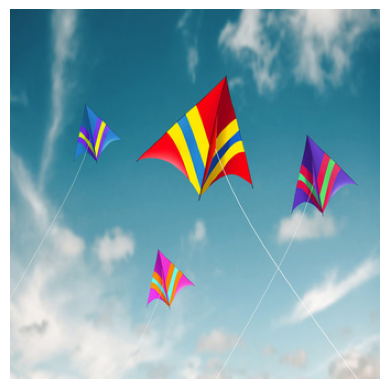

In [ ]:
#@title Generate Caption for an Image

def generate_image_caption(encoder, decoder, image_path, word_map, beam_size=5):
    """
    Takes in an image and captions it
    """
    k = beam_size

    img = np.array(Image.open(image_path).convert('RGB'))
    img = cv2.resize(img, (256, 256))

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img = transform(img)

    # Encode
    encoder_out = encoder(img.unsqueeze(0).to(device))
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten
    encoder_out = encoder_out.view(1, -1, encoder_dim)
    num_pixels = encoder_out.size(1)

    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)

    # Initialize top previous words tensor
    top_k_prev_words = torch.tensor([[word_map['<start>']]] * k, dtype=torch.long).to(device)

    # Initialize top sequences tensor
    top_k_seqs = top_k_prev_words

    # Initialize top sequences scores tensor
    top_k_scores = torch.zeros(k, 1).to(device)

    # Initialize top sequences alphas tensor
    top_k_seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)

    # Initialize lists for sequences and their scores/alphas
    complete_seqs = []
    complete_seqs_scores = []

    # Decode
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    while True:
        embeddings = decoder.embedding(top_k_prev_words).squeeze(1)
        attention_weighted_encoding, alpha = decoder.attention(encoder_out, h)

        gate = F.sigmoid(decoder.f_beta(h))
        attention_weighted_encoding = gate * attention_weighted_encoding

        h, c = decoder.decode_step(
            torch.cat([embeddings, attention_weighted_encoding], dim=1), (h, c))

        scores = decoder.fc(h)
        scores = F.log_softmax(scores, dim=1)
        scores = top_k_scores.expand_as(scores) + scores

        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
        else:
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)

        prev_word_inds = top_k_words // vocab_size
        next_word_inds = top_k_words % vocab_size

        top_k_seqs = torch.cat([top_k_seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)

        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds)
                            if next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        if len(complete_inds) > 0:
            complete_seqs.extend(top_k_seqs[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)

        if k == 0:
            break

        top_k_seqs = top_k_seqs[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        top_k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]

    caption = [id2word[ind] for ind in seq]

    img = Image.open(image_path).convert('RGB')
    print(' '.join(caption[1:-1]))
    plt.axis('off')
    plt.imshow(img)


image_url = 'https://t4.ftcdn.net/jpg/03/12/86/67/360_F_312866728_hTb0ks4uM9aM8hAHItFK46zAEDzPhsTE.jpg' #@param {type:"string"}
beam_size =  5 #@param {type: "number"}

checkpoint = torch.load('/content/drive/MyDrive/Projects/ImageCaptioning/test/image_captioning_best.pth', map_location=device)

encoder = checkpoint['encoder']
decoder = checkpoint['decoder']

vocab_size = len(word2id)
image_path = 'picture.png'

generate_image_caption(encoder, decoder, image_path, word2id, beam_size)
